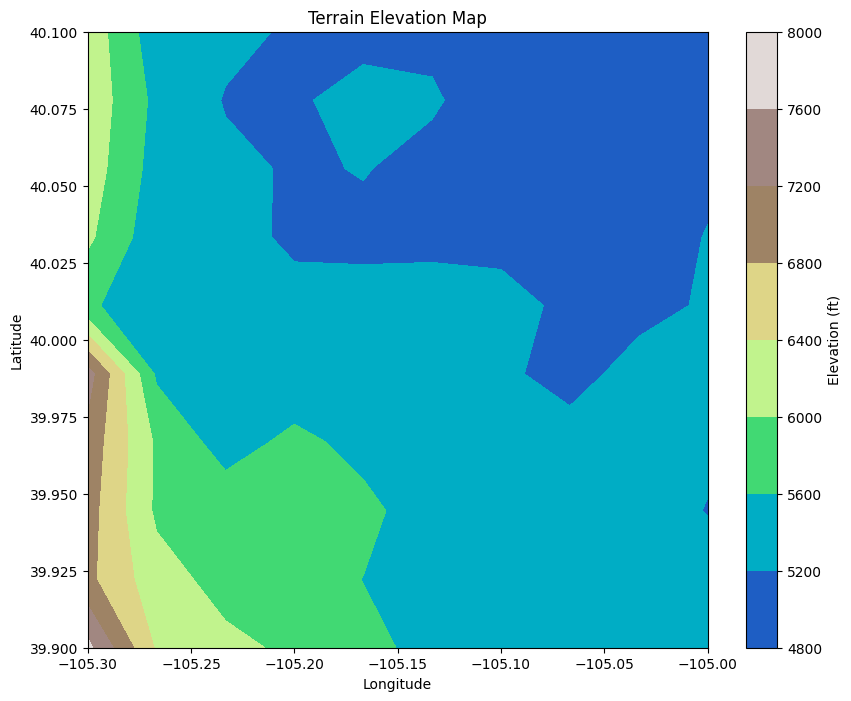

In [5]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import time

# Function to get elevation for a specific point (lat, lon)
def get_elevation(lat, lon):
    url = f"https://epqs.nationalmap.gov/v1/json?x={lon}&y={lat}&wkid=4326&units=Feet&includeDate=false"
    
    try:
        # Request data from the API
        response = requests.get(url)
        
        # Check if the response is OK (status code 200)
        if response.status_code != 200:
            print(f"Error: Received status code {response.status_code} for point ({lat}, {lon})")
            return None
        
        # Parse the JSON response
        data = response.json()

        # Extract the elevation value
        elevation = data.get('value')
        if elevation is None:
            print(f"No elevation data available for point ({lat}, {lon})")
            return None
        
        # Extract additional information (optional)
        resolution = data.get('resolution')
        raster_id = data.get('rasterId')

        # Return the elevation along with other data
        return {
            'elevation': float(elevation),
            'resolution': resolution,
            'raster_id': raster_id
        }
    
    except requests.exceptions.RequestException as e:
        print(f"Request exception for point ({lat}, {lon}): {e}")
        return None
    except ValueError as e:
        print(f"Error parsing JSON for point ({lat}, {lon}): {e}")
        return None

# Function to generate a grid of latitude and longitude points over an area
def generate_grid(lat_min, lat_max, lon_min, lon_max, grid_size):
    lat_points = np.linspace(lat_min, lat_max, grid_size)
    lon_points = np.linspace(lon_min, lon_max, grid_size)
    return np.meshgrid(lat_points, lon_points)

# Function to gather elevation data for a grid of points
def get_elevation_grid(lat_min, lat_max, lon_min, lon_max, grid_size):
    lats, lons = generate_grid(lat_min, lat_max, lon_min, lon_max, grid_size)
    elevation_grid = np.zeros(lats.shape)

    for i in range(lats.shape[0]):
        for j in range(lats.shape[1]):
            result = get_elevation(lats[i, j], lons[i, j])
            if result:
                elevation_grid[i, j] = result['elevation']
            else:
                elevation_grid[i, j] = np.nan
            time.sleep(0.5)  # Delay to avoid hitting API limits

    return lats, lons, elevation_grid

# Visualization of the terrain
def plot_terrain(lat_grid, lon_grid, elevation_grid):
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(lon_grid, lat_grid, elevation_grid, cmap='terrain')
    plt.colorbar(contour, ax=ax, label='Elevation (ft)')
    ax.set_title('Terrain Elevation Map')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

# Define the bounding box for the area (latitude/longitude range)
lat_min = 39.90  # Minimum latitude
lat_max = 40.10  # Maximum latitude
lon_min = -105.30  # Minimum longitude
lon_max = -105.00  # Maximum longitude

# Define the size of the grid (more points = finer detail, but more requests)
grid_size = 10

# Get elevation data for the grid
lat_grid, lon_grid, elevation_grid = get_elevation_grid(lat_min, lat_max, lon_min, lon_max, grid_size)

# Plot the terrain based on elevation data
plot_terrain(lat_grid, lon_grid, elevation_grid)


In [3]:
import pandas as pd
import sys
import requests
import numpy as np
import math
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed
from ratelimit import limits, sleep_and_retry
from itertools import combinations
from scipy.stats import skew, kurtosis
import argparse
import os
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Constants
CALLS = 5
RATE_LIMIT = 1
EARTH_RADIUS_M = 6371000
FEET_TO_METERS = 0.3048
SQUARE_FEET_PER_ACRE = 43560

@sleep_and_retry
@limits(calls=CALLS, period=RATE_LIMIT)
def get_elevation(session, lat, lon):
    """Fetch elevation data from the USGS Elevation Point Query Service."""
    url = f"https://epqs.nationalmap.gov/v1/json?x={lon}&y={lat}&wkid=4326&units=Feet&includeDate=false"
    
    try:
        response = session.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data.get('value')
    except requests.exceptions.RequestException as e:
        logger.error(f"Request exception for point ({lat}, {lon}): {e}")
        return None

def get_offset_from_acreage(acreage, percentage):
    """Calculate the offset distance based on acreage and percentage."""
    side_length = math.sqrt(acreage * SQUARE_FEET_PER_ACRE)
    move_distance_ft = side_length * percentage
    return move_distance_ft / 364000

def calculate_slope(elevation1, elevation2, lat1, lon1, lat2, lon2):
    """Calculate the slope between two points."""
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = EARTH_RADIUS_M * c  # Distance in meters
    
    elevation1_m = elevation1 * FEET_TO_METERS
    elevation2_m = elevation2 * FEET_TO_METERS
    
    elevation_diff = elevation2_m - elevation1_m
    slope = elevation_diff / distance if distance > 0 else 0
    return slope, abs(slope)

def analyze_terrain(session, lat, lon, acreage):
    """Analyze the terrain for a given location."""
    percentage_movement = 0.3
    offset = get_offset_from_acreage(acreage, percentage_movement)
    
    directions = {
        'Center': (lat, lon),
        'North': (lat + offset, lon),
        'South': (lat - offset, lon),
        'East': (lat, lon + offset),
        'West': (lat, lon - offset),
        'Northeast': (lat + offset, lon + offset),
        'Northwest': (lat + offset, lon - offset),
        'Southeast': (lat - offset, lon + offset),
        'Southwest': (lat - offset, lon - offset)
    }
    
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_direction = {executor.submit(get_elevation, session, dlat, dlon): (direction, dlat, dlon) 
                               for direction, (dlat, dlon) in directions.items()}
        
        elevations = {}
        for future in as_completed(future_to_direction):
            direction, dlat, dlon = future_to_direction[future]
            try:
                elevation = future.result()
                if elevation is not None:
                    elevations[direction] = (elevation, dlat, dlon)
            except Exception as e:
                logger.error(f"Error processing {direction}: {e}")
    
    if len(elevations) < 2:
        logger.warning(f"Not enough valid elevations for point ({lat}, {lon})")
        return None
    
    slopes = []
    abs_slopes = []
    for (dir1, (elev1, lat1, lon1)), (dir2, (elev2, lat2, lon2)) in combinations(elevations.items(), 2):
        slope, abs_slope = calculate_slope(elev1, elev2, lat1, lon1, lat2, lon2)
        slopes.append(slope)
        abs_slopes.append(abs_slope)
    
    # Calculate various statistical measures
    mean_slope = np.mean(abs_slopes)
    max_slope = np.max(abs_slopes)
    slope_range = np.ptp(slopes)
    slope_std = np.std(slopes)
    slope_skewness = skew(slopes)
    slope_kurtosis = kurtosis(slopes)
    
    # Calculate elevation range and standard deviation
    elev_values = [e for e, _, _ in elevations.values()]
    elev_range = np.ptp(elev_values)
    elev_std = np.std(elev_values)
    
    # Scoring
    scores = {
        'flatness': 1 / (1 + mean_slope),
        'consistency': 1 / (1 + slope_std),
        'variability': 1 / (1 + slope_range),
        'extremity': 1 / (1 + max_slope),
        'symmetry': 1 / (1 + abs(slope_skewness)),
        'peakedness': 1 / (1 + abs(slope_kurtosis)),
        'elev_range': 1 / (1 + elev_range / 100),
        'elev_consistency': 1 / (1 + elev_std)
    }
    
    # Weights
    weights = {
        'flatness': 0.10,
        'consistency': 0.08,
        'variability': 0.30,
        'extremity': 0.20,
        'symmetry': 0.05,
        'peakedness': 0.05,
        'elev_range': 0.20,
        'elev_consistency': 0.15
    }
    
    # Calculate weighted score
    final_score = sum(scores[key] * weights[key] for key in scores)
    
    # Terrain type classification
    terrain_types = [
        (0.95, "Very Flat"),
        (0.90, "Flat"),
        (0.85, "Mostly Flat"),
        (0.80, "Slightly Undulating"),
        (0.75, "Gently Undulating"),
        (0.70, "Moderately Undulating"),
        (0.65, "Undulating"),
        (0.60, "Hilly"),
        (0.55, "Very Hilly"),
        (0.50, "Mountainous"),
        (0.00, "Extremely Mountainous")
    ]
    
    terrain_type = next(type for score, type in terrain_types if final_score >= score)
    
    # Calculate additional factors
    slope_complexity = np.std(abs_slopes) / np.mean(abs_slopes)  # Coefficient of variation
    elevation_complexity = elev_std / np.mean(elev_values)  # Coefficient of variation
    
    return {
        'final_score': final_score,
        **{f'{key}_score': value for key, value in scores.items()},
        'mean_slope': mean_slope,
        'max_slope': max_slope,
        'slope_range': slope_range,
        'slope_std': slope_std,
        'elev_range': elev_range,
        'elev_std': elev_std,
        'terrain_type': terrain_type,
        'slope_complexity': slope_complexity,
        'elevation_complexity': elevation_complexity
    }

def process_properties(input_file, output_file, sample_size=100):
    """Process properties from the input file and save results to the output file."""
    try:
        df = pd.read_excel(input_file)
    except Exception as e:
        logger.error(f"Error reading input file: {e}")
        return

    required_columns = ['LATITUDE', 'LONGITUDE', 'Lot Acres']
    if not all(col in df.columns for col in required_columns):
        logger.error("Error: Excel file must contain 'LATITUDE', 'LONGITUDE', and 'Lot Acres' columns.")
        return
    
    # Sample the dataframe if necessary
    if len(df) > sample_size:
        df = df.sample(sample_size, random_state=42)
    
    # Define the new columns we want to add
    new_columns = ['Terrain Score', 'Terrain Type']
    
    for col in new_columns:
        df[col] = None
    
    with requests.Session() as session:
        with ThreadPoolExecutor(max_workers=5) as executor:
            futures = {executor.submit(analyze_terrain, session, row['LATITUDE'], row['LONGITUDE'], row['Lot Acres']): idx 
                       for idx, row in df.iterrows()}
            
            for future in tqdm(as_completed(futures), total=len(futures), desc="Processing properties"):
                idx = futures[future]
                try:
                    result = future.result()
                    if result is not None:
                        df.at[idx, 'Terrain Score'] = result['final_score']
                        df.at[idx, 'Terrain Type'] = result['terrain_type']
                        logger.info(f"Processed property at index {idx}")
                    else:
                        logger.warning(f"Unable to calculate terrain score for property at index {idx}")
                except Exception as e:
                    logger.error(f"Error processing property at index {idx}: {e}")

    try:
        df.to_excel(output_file, index=False)
        logger.info(f"Processed data saved to '{output_file}'.")
    except Exception as e:
        logger.error(f"Error saving output file: {e}")


def main():
    if 'ipykernel' in sys.modules:
        # Running in IPython environment
        input_file = "sampled_properties.xlsx"
        output_file = "properties_with_terrain_scores.xlsx"
        sample_size = 50
    else:
        # Running from command line
        parser = argparse.ArgumentParser(description="Process property data and analyze terrain.")
        parser.add_argument("--output_file", default="properties_with_terrain_scores.xlsx",
                            help="Path to the output Excel file (default: properties_with_terrain_scores.xlsx)")
        parser.add_argument("--sample_size", type=int, default=100,
                            help="Number of properties to sample (default: 100)")
        args = parser.parse_args()
        input_file = "sampled_properties.xlsx"
        output_file = args.output_file
        sample_size = args.sample_size

    if not os.path.exists(input_file):
        logger.error(f"Input file '{input_file}' does not exist.")
        return

    process_properties(input_file, output_file, sample_size)

if __name__ == "__main__":
    main()

Processing properties:   0%|          | 0/50 [00:00<?, ?it/s]2024-09-18 00:39:34,290 - WARNING - Connection pool is full, discarding connection: epqs.nationalmap.gov. Connection pool size: 10
2024-09-18 00:39:34,309 - WARNING - Connection pool is full, discarding connection: epqs.nationalmap.gov. Connection pool size: 10
2024-09-18 00:39:34,321 - WARNING - Connection pool is full, discarding connection: epqs.nationalmap.gov. Connection pool size: 10
2024-09-18 00:39:35,861 - INFO - Processed property at index 29
Processing properties:   4%|▍         | 2/50 [00:10<03:57,  4.95s/it]2024-09-18 00:39:41,565 - ERROR - Request exception for point (44.319693, -85.74596572126887): HTTPSConnectionPool(host='epqs.nationalmap.gov', port=443): Read timed out. (read timeout=10)
2024-09-18 00:39:42,580 - ERROR - Request exception for point (44.319115278731125, -85.74596572126887): HTTPSConnectionPool(host='epqs.nationalmap.gov', port=443): Read timed out. (read timeout=10)
2024-09-18 00:39:42,583 - 